In [55]:
import numpy as np, matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
import scipy

In [56]:
# Read in the mc
neutrinos = np.genfromtxt("./neutrino_mc.csv", delimiter=',', names=True)
muons = np.genfromtxt("./muon_mc.csv", delimiter=',', names=True)

In [57]:
# Read in the hyperplane parameters
hp_nue_cc = np.genfromtxt("./hyperplanes_nue_cc.csv", delimiter=',', names=True)
hp_numu_cc = np.genfromtxt("./hyperplanes_numu_cc.csv", delimiter=',', names=True)
hp_nutau_cc = np.genfromtxt("./hyperplanes_nutau_cc.csv", delimiter=',', names=True)
hp_nu_nc = np.genfromtxt("./hyperplanes_all_nc.csv", delimiter=',', names=True)
hp_muons = np.genfromtxt("hyperplanes_muon.csv", delimiter=',', names=True)

In [58]:
# The bestfit values for Analysis A NC+CC from Table 2
best_fit = {'ice_absorption': 101.5,
            'ice_scattering': 103.0,
            'opt_eff_headon': -0.63,
            'opt_eff_lateral': 0.49,
            'opt_eff_overall': 98.4,
            'coin_fraction': 0.01,
            'delta_m32': 2.53e-3,
            'theta_23': 49.8,
            'nu_tau_norm': 0.73,
            'NC_norm': 1.05}

In [59]:
# Write the function definition for neutrinos
# This will take the values for each parameter and return
# the modified weight for each event
def apply_neutrinos(neutrinos=neutrinos,
                    hyperplanes = {0: hp_nu_nc,
                                   12: hp_nue_cc,
                                   14: hp_numu_cc,
                                   16: hp_nutau_cc,},
                    ice_absorption = 100.0,
                    ice_scattering = 100.0,
                    opt_eff_headon = 0.0,
                    opt_eff_lateral = 0.0,
                    opt_eff_overall = 100.0,
                    coin_fraction = 0.0,
                    **kwargs):
    
    # Copy the weights so we can modify them and 
    # assign an "interaction type" corresponding to
    # nue CC, numu CC, nutau CC or NC
    output_weights = np.copy(neutrinos['weight'])
    int_type = np.copy(neutrinos['pdg']).astype(int)
    int_type[neutrinos['type']==0] = 0 
    int_type = np.abs(int_type)

    # Apply each neutrino flavor separately using the PDG
    # codes for each. Note that we're using 0 for NC interactions
    # and 12/14/16 for nue/numu/nutau CC interactions respectively
    for flavor, hp in hyperplanes.items():
        bins_cz = hyperplanes[flavor]['reco_coszen']
        bins_en = hyperplanes[flavor]['reco_energy']
        bins_pid = hyperplanes[flavor]['pid']
        bins = np.array([bins_cz, bins_en, bins_pid]).T
        
        modifications = hp['offset'] + \
                        hp['ice_scattering'] * (ice_scattering-100)/100. +\
                        hp['ice_absorption'] * (ice_absorption-100)/100. +\
                        hp['opt_eff_lateral'] * (10*opt_eff_lateral) +\
                        hp['opt_eff_headon'] * (opt_eff_headon) +\
                        hp['opt_eff_overall'] * (opt_eff_overall-100)/100. +\
                        hp['coin_fraction'] * (coin_fraction)
        
        # Apply the modifications for a single neutrino flavor
        for i, b in enumerate(bins):
            mask = (int_type==flavor)
            mask &= (neutrinos['reco_coszen'] == b[0])
            mask &= (neutrinos['reco_energy'] == b[1])
            mask &= (neutrinos['pid'] == b[2])
            output_weights[mask] *= modifications[i]
        
    return output_weights
        

In [60]:
# Write the function definition for muons
# This will take the values for each parameter and return
# the modified weight for each event
def apply_muons(muons=muons,
                hyperplane = hp_muons,
                ice_absorption = 100.0,
                ice_scattering = 100.0,
                opt_eff_headon = 0.0,
                opt_eff_lateral = 0.0,
                opt_eff_overall = 100.0,
                **kwargs):
    
    # Copy the weights so we can modify them
    output_weights = np.copy(muons['weight'])

    # Get the bins for the muons
    bins_cz = hyperplane['reco_coszen']
    bins_en = hyperplane['reco_energy']
    bins_pid = hyperplane['pid']
    bins = np.array([bins_cz, bins_en, bins_pid]).T
        
    modifications = hyperplane['offset'] +\
        hyperplane['ice_scattering']*(ice_scattering-100)/100. +\
        hyperplane['opt_eff_lateral']*(10*opt_eff_lateral) +\
        hyperplane['opt_eff_headon']*(opt_eff_headon) +\
        hyperplane['ice_absorption']*(np.exp(hyperplane['ice_absorption_expslope']*(ice_absorption/100.-1.0))-1) +\
        hyperplane['opt_eff_overall']*(np.exp(hyperplane['opt_eff_overall_expslope']*(opt_eff_overall/100.-1.0))-1)

    total_mask = np.zeros(len(muons)).astype(int)

    # Apply the modifications to the muon weights
    for i, b in enumerate(bins):
        mask = (muons['reco_coszen'] == b[0])
        mask &= (muons['reco_energy'] == b[1])
        mask &= (muons['pid'] == b[2])
        output_weights[mask] *= modifications[i]
        total_mask += mask.astype(int)

    assert (total_mask == 1).all(), "Some muons were not modified, or modified more than once!"
    
    return output_weights
        

In [61]:
# Sanity checks for the code above so that the masks work as intended
for variable in ["reco_energy", "reco_coszen", "pid"]:
    hp_unique = np.sort(np.unique(hp_muons[variable]))
    for hp_plane in [hp_nu_nc, hp_nue_cc, hp_numu_cc, hp_nutau_cc]:
        assert np.all(np.sort(np.unique(hp_plane[variable])) == hp_unique)
    
    for dataset, hp_plane in zip([muons, neutrinos], [hp_muons, hp_nu_nc]):
        assert np.all(np.sort(np.unique(muons[variable])) == np.sort(np.unique(hp_plane[variable])))

In [62]:
def get_honda_fluxes(filename: str = "nu_flux_honda_table.txt"):
    # Create a dict with the pdg as key and an array as value.
    # The arrays are of shape (n, 3) with the energy, cosZ angle, and flux
    fluxes = {-14: [], -12: [], 12: [], 14: []}

    with open(filename) as f:
        for line in f:
            # If the line starts without a space, it contains the cosZ value range (which we take the average over)
            if line[0] != " ":
                cos1, cos2 = float(line[23:27]), float(line[32:36])
                # To make the interpolation work for all values of cosZ, place the outermost points at the edges, i.e., 1 and -1
                if cos1 == 1. or cos2 == 1.:
                    cosZ = 1.
                elif cos1 == -1. or cos2 == -1.:
                    cosZ = -1
                # For other values of cosZ, take the average of the upper and lower bounds
                else:
                    cosZ = (cos1 + cos2)/2
                continue
            
            # If the line starts with a space but the second , it contains numbers
            elif not line[1].isnumeric():
                continue
            
            # Otherwise, it contains the energy and fluxes
            energy, numu_flux, numubar_flux, nue_flux, nuebar_flux = [float(value) for value in line.split()]
            fluxes[12].append([energy, cosZ, nue_flux])
            fluxes[14].append([energy, cosZ, numu_flux])
            fluxes[-12].append([energy, cosZ, nuebar_flux])
            fluxes[-14].append([energy, cosZ, numubar_flux])
    # TODO check that the angle is read correctly.
    fluxes = {key: np.array(value) for key, value in fluxes.items()}
    flux_interpolators = {pdg: scipy.interpolate.LinearNDInterpolator(value[:, :2], value[:, 2]) for pdg, value in fluxes.items()}
    return flux_interpolators


def apply_flux(neutrinos=neutrinos,
               delta_m32: float = 2.53e-3, # eV^2
               theta_23: float = 49.8, # Degrees
               **kwargs):
    """
    Calculate the flux for the neutrinos based on their true energy and cosZ.
    The Honda flux tables are used.

    Also apply neutrino oscillation probabilities to the weights.
    The weight of a certain (cosZtrue, Etrue) nu_mu is multiplied by P(nu_mu -> nu_mu)
    The weight of a certain (cosZtrue, Etrue) nu_tau is multiplied by P(nu_mu -> nu_tau)
    """
    flux_interpolators = get_honda_fluxes()
    # Apply oscillation probabilities
    oscillation_weights = oscillation_probabilities(neutrinos=neutrinos,
                                delta_m32=delta_m32,
                                theta_23=theta_23)
    # Multiply oscillation weights with the fluxes, where the nu_tau fluxes are simply the muon fluxes
    for pdg in np.unique(neutrinos["pdg"]):
        mask = neutrinos['pdg'] == pdg
        if pdg == 16:
            interpolator = flux_interpolators[14]
        elif pdg == -16:
            interpolator = flux_interpolators[-14]
        else:
            interpolator = flux_interpolators[pdg]

        interpolated_flux = interpolator(neutrinos[mask]['true_energy'], neutrinos[mask]['true_coszen'])
        
        # If the energy of the neutrino is outside the energy range given by the Honda flux table, there are 3 options:
        # - use the flux of the maximum energy allowed by the Honda table, which is 10_000.
        # - drop the events entirely
        # - TODO Use the approximation of E^(-3.7) from the last two points in the Honda table for that zenith angle and extrapolate.
        if (nan_loc := np.isnan(interpolated_flux)).any():
            interpolated_flux[nan_loc] = 0 #interpolator(1e4, neutrinos[mask][nan_loc]["true_coszen"])
        
        oscillation_weights[mask] *= interpolated_flux

    # convert from flux in #particles / (m^2 sec sr GeV) to #particles / sec
    # The cross section of DeepCore depends on the zenith angle
    # but I assume it to be the same for all angles for now.
    # In that case, the cross section does not really matter, since we normalize the events to the number of neutrinos.
    # It is approximately 300 m x 300 m x 300 m, based on Fig. 1 in the paper.
    # NOTE: I cannot multiply by the energy, as that results in a massive discrepancy. 
    # I guess the weights already take it into account, or there is something with integration that makes it unnecessary.
    # oscillation_weights *= 300**2 * neutrinos["true_energy"]
    
    return oscillation_weights


def oscillation_probabilities(neutrinos=neutrinos, 
                       delta_m32: float = 2.53e-3, # eV^2
                       theta_23: float = 49.8, # Degrees
                       **kwargs):
    """
    Calculate neutrino oscillation probabilities.
    For electrons, we set the weights to 1.
    For muons, the return value is P(nu_mu -> nu_mu) = 1 - P(nu_mu -> nu_tau)
    For taus, the return value is P(nu_mu -> nu_tau)
    """
    probabilities = np.ones(neutrinos.shape[0])
    
    is_nu_mu = np.abs(neutrinos['pdg']) == 14
    is_nu_tau = np.abs(neutrinos['pdg']) == 16

    r = 1.3e4/2 # Earth radius [km]
    a = 20 # distance from atmosphere to IceCube [km]
    # Calculate distance traveled by the neutrinos as a function of their true cosZ.
    # This equation can be derived using simple geometry and the law of cosines
    distance = neutrinos["true_coszen"] * (r-a) + np.sqrt(neutrinos["true_coszen"]**2 * (r-a)**2 - (a**2 - 2*a*r))
    assert np.all(distance >= 20), "Distance is negative!"
    # TODO check this angle dependence, as I might have done something incorrectly.
    probabilities[is_nu_mu] = 1 - np.sin(2*np.deg2rad(theta_23))**2 * np.sin(1.27 * delta_m32 * distance[is_nu_mu] / neutrinos[is_nu_mu]['true_energy'])**2
    probabilities[is_nu_tau] = np.sin(2*np.deg2rad(theta_23))**2 * np.sin(1.27 * delta_m32 * distance[is_nu_tau] / neutrinos[is_nu_tau]['true_energy'])**2

    assert np.all(probabilities >= 0), "Probabilities are negative!"
    assert np.all(probabilities <= 1), "Probabilities are greater than 1!"
    
    return probabilities


def muon_norm(muon_weights, n_muons):
    """Calculate the normalization constant for muons"""
    mc_count = np.sum(muon_weights)
    return n_muons / mc_count


def neutrino_norm(neutrinos=neutrinos, nu_tau_norm=1., NC_norm=1., **kwargs):
    """
    Apply the normalization factors to the neutrino weights.
    """
    weights = np.ones(neutrinos['weight'].shape)
    # Tau neutrino normalization (table II)
    weights[np.abs(neutrinos['pdg']) == 16] *= nu_tau_norm
    # NC normalization (table II)
    weights[neutrinos['type'] == 0] *= NC_norm
    return weights

def neutrino_total_norm(neutrino_weights, n_neutrinos):
    """Normalize the total neutrino count to be the same as in table I"""
    return n_neutrinos / neutrino_weights.sum()


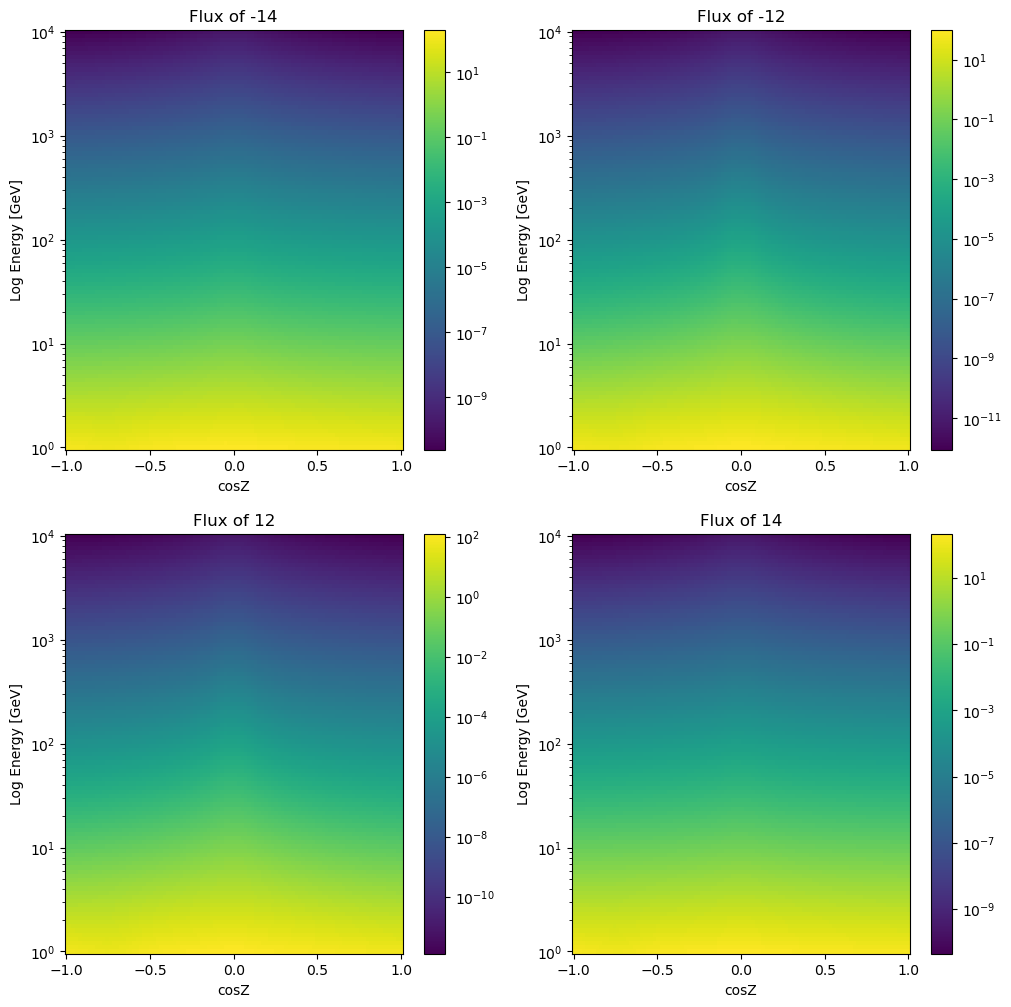

In [63]:
interpolators = get_honda_fluxes()
# Create a 2D grid of cosZ and energy values
cosZ = np.linspace(-1, 1, 100)
energy = np.logspace(0, 4, 100)
cosZ, energy = np.meshgrid(cosZ, energy)
# Interpolate the fluxes for the different neutrino flavors
fluxes = {pdg: interpolator(energy, cosZ) for pdg, interpolator in interpolators.items()}
# Plot the fluxes
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
for i, (pdg, flux) in enumerate(fluxes.items()):
    ax = axs[i//2, i%2]
    map = ax.pcolormesh(cosZ, energy, flux, shading='auto', norm=matplotlib.colors.LogNorm())
    ax.set_xscale('linear')
    ax.set_yscale('log')
    ax.set_title(f"Flux of {pdg}")
    ax.set_xlabel("cosZ")
    ax.set_ylabel("Log Energy [GeV]")
    cbar = plt.colorbar(map, ax=ax)

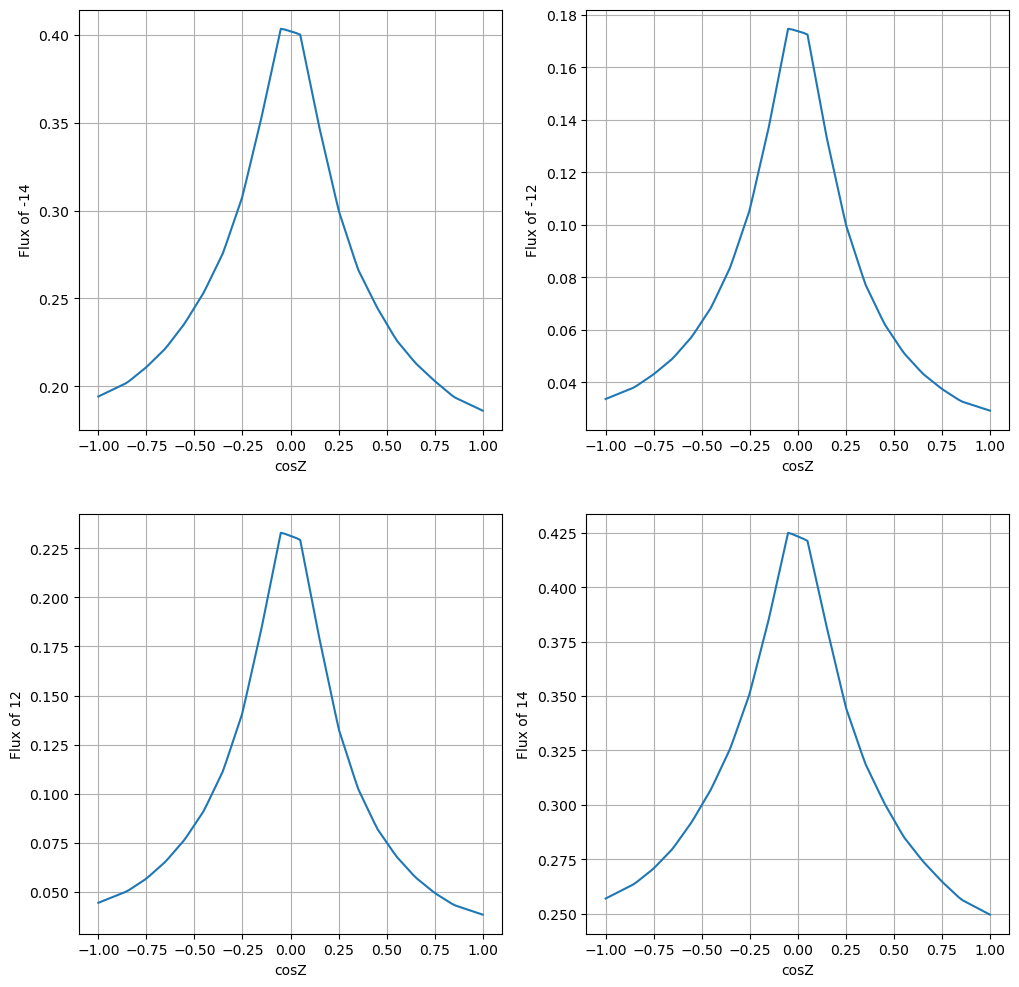

In [64]:
# Create a 2D grid of cosZ and energy values
cosZ = np.linspace(-1, 1, 100)
# Interpolate the fluxes for the different neutrino flavors
fluxes = {pdg: interpolator(10, cosZ) for pdg, interpolator in interpolators.items()}
# Plot the fluxes
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
for i, (pdg, flux) in enumerate(fluxes.items()):
    ax = axs[i//2, i%2]
    ax.plot(cosZ, flux)
    ax.set_ylabel(f"Flux of {pdg}")
    ax.set_xlabel("cosZ")
    ax.grid()

## Plot MC data
With weights on each event based on detector efficiency etc.
Something seems to be wrong, as the MC distributions are not close to the data distributions.

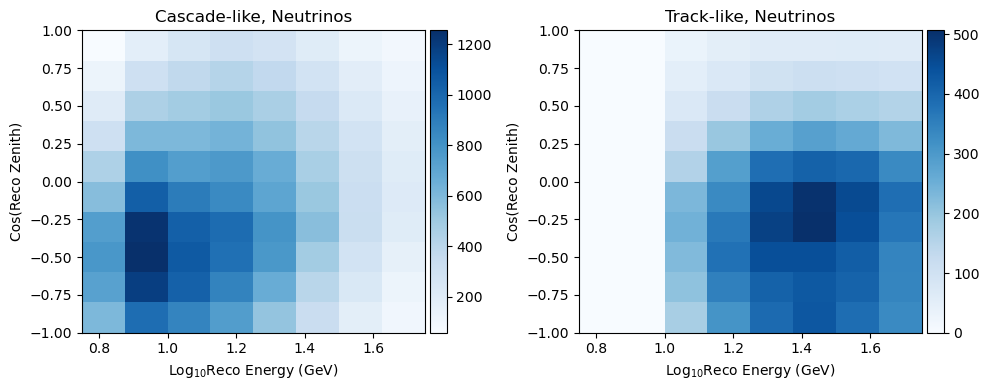

In [65]:
# Make a plot of the neutrinos just to verify the shape is correct
bins_en = np.log10([5.623413,  7.498942, 10. , 
                    13.335215, 17.782795, 23.713737, 
                    31.622776, 42.16965 , 56.23413])
bins_cz = np.array([-1., -0.8, -0.6 , -0.4, -0.2, 
                    0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
bins_pid = np.array([0, 1, 2])

# Choose the nuisance parameters for the detector systematics
#neutrino_weights = neutrino_muons()
neutrino_weights = apply_neutrinos(**best_fit)

# A flux model must be assumed for the neutrinos
# Here, use a simple flux of phi=800*E^-3.7 
# Note that this is only for the purposes of an
# example: fits performed using this sample should
# use a numerical flux calculation such as the one
# presented in PhysRevD.92.023004
# I also apply neutrino oscillation probabilities
neutrino_weights *= apply_flux(**best_fit)
# Scale to the livetime of the data
neutrino_weights *= 1006*24*3600. 
# Scale neutrino weights based on the normalization constants for NC and nu_tau nuisance parameters
neutrino_weights *= neutrino_norm(**best_fit)
# Scale the neutrino weights based on the total number of neutrinos according to table I
neutrino_weights *= neutrino_total_norm(neutrino_weights=neutrino_weights, n_neutrinos=62203-5022-93)

# Make the histogram, binning in energy, zenith, and pid
nu_hist, edges = np.histogramdd([np.log10(neutrinos['reco_energy']),
                                 neutrinos['reco_coszen'],
                                 neutrinos['pid']],
                                bins = [bins_en, bins_cz, bins_pid],
                                weights = neutrino_weights)
nu_hist = np.swapaxes(nu_hist, 0, 1)

# Calculate the weighted error of each bin on the histogram
# TODO this might be an incorrect way of calculating the statistical error 
# caused by the limited MC statistics
# Source: https://stackoverflow.com/questions/48227037/error-on-weighted-histogram-in-python
nu_err = np.sqrt(
    np.histogramdd([np.log10(neutrinos['reco_energy']),
                    neutrinos['reco_coszen'],
                    neutrinos['pid']],
    bins = [bins_en, bins_cz, bins_pid],
    weights = neutrino_weights**2)[0]
)
# Swap axis 0 and 1 to match the data format and for easier plotting
nu_err = np.swapaxes(nu_err, 0, 1)

# Make a figure
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 4))
cmesh = ax1.pcolormesh(bins_en, 
                       bins_cz,
                       nu_hist[:,:,0],
                       cmap='Blues')
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(cmesh, cax)

cmesh = ax2.pcolormesh(bins_en, 
                       bins_cz,
                       nu_hist[:,:,1],
                       cmap='Blues')
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(cmesh, cax)

ax1.set_title('Cascade-like, Neutrinos')
ax1.set_ylabel("Cos(Reco Zenith)")
ax1.set_xlabel(r"Log$_{10}$Reco Energy (GeV)")
ax2.set_ylabel("Cos(Reco Zenith)")
ax2.set_xlabel(r"Log$_{10}$Reco Energy (GeV)")
ax2.set_title('Track-like, Neutrinos')

fig.tight_layout()

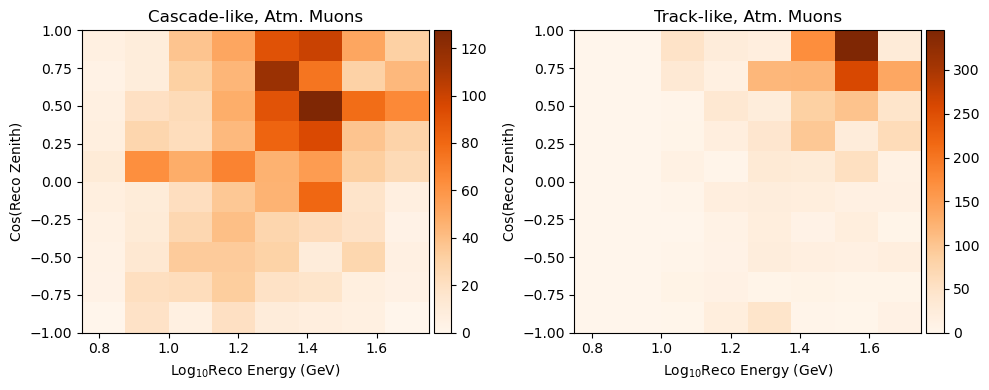

In [66]:
# Make a plot of the muons just to verify the shape is correct
bins_en = np.log10([5.623413,  7.498942, 10. , 
                    13.335215, 17.782795, 23.713737, 
                    31.622776, 42.16965 , 56.23413])
bins_cz = np.array([-1., -0.8, -0.6 , -0.4, -0.2, 
                    0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
bins_pid = np.array([0, 1, 2])

# Choose the nuisance parameters for the detector systematics
#muon_weights = np.copy(muons['weight'])
#muon_weights = apply_muons()
muon_weights = apply_muons(**best_fit)

# Weights are in Hz. Convert to about the 
# livetime given in Section IV
# Corresponding to the number of seconds that the experiment was live. 
# Roughly 3 years.
muon_weights *= 1006*24*3600. 

# Scale the number of events so that they match the numbers in table I
muon_weights *= muon_norm(muon_weights, 5022)

# Make the histogram, binning in energy, zenith, and pid
muon_hist, edges = np.histogramdd([np.log10(muons['reco_energy']),
                                   muons['reco_coszen'],
                                   muons['pid']],
                                  bins = [bins_en, bins_cz, bins_pid],
                                  weights = muon_weights)
muon_hist = np.swapaxes(muon_hist, 0, 1)
# Calculate the weighted error of each bin on the histogram
# TODO this might be an incorrect way of calculating the statistical error 
# caused by the limited MC statistics. See same code above for neutrinos
muon_err = np.sqrt(
    np.histogramdd([np.log10(muons['reco_energy']),
                    muons['reco_coszen'],
                    muons['pid']],
        bins = [bins_en, bins_cz, bins_pid],
        weights = muon_weights**2)[0]
)
muon_err = np.swapaxes(muon_err, 0, 1)

# Make a figure
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 4))
cmesh = ax1.pcolormesh(bins_en, 
                       bins_cz,
                       muon_hist[:,:,0],
                       cmap='Oranges')
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(cmesh, cax)

cmesh = ax2.pcolormesh(bins_en, 
                       bins_cz,
                       muon_hist[:,:,1],
                       cmap='Oranges')
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(cmesh, cax)

ax1.set_title('Cascade-like, Atm. Muons')
ax1.set_ylabel("Cos(Reco Zenith)")
ax1.set_xlabel(r"Log$_{10}$Reco Energy (GeV)")
ax2.set_ylabel("Cos(Reco Zenith)")
ax2.set_xlabel(r"Log$_{10}$Reco Energy (GeV)")
ax2.set_title('Track-like, Atm. Muons')

fig.tight_layout()

^ This plot should look like Figure 12 in the paper, but does not. 
Something with the weights is wrong, or I have misunderstood the output or the plot in the paper.

## Plot actual detected data

In [67]:
data = np.genfromtxt("./data.csv", delimiter=',', names=True)

In [68]:
cascades = data[data["pid"] == 0]
tracks = data[data["pid"] == 1]

# Reshape the count column in the cascade array into a 2D array. 
# The rows should correspond to a sorted reco_coszen and the columns should be the sorted reco_energy
cascades_count = cascades["count"].reshape((len(bins_en)-1, len(bins_cz)-1)).T[::-1, ...]
track_count = tracks["count"].reshape((len(bins_en)-1-2, len(bins_cz)-1)).T[::-1, ...]

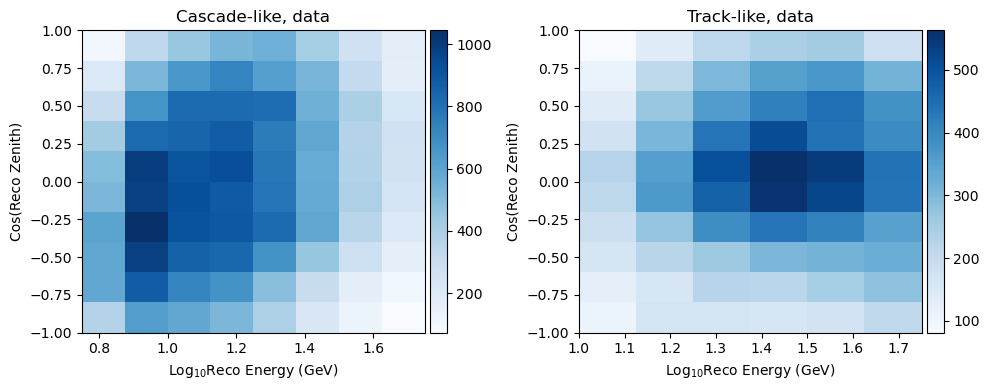

In [69]:
# Make a figure
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 4))
cmesh = ax1.pcolormesh(bins_en, 
                       bins_cz,
                       cascades_count,
                       cmap='Blues')
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(cmesh, cax)

cmesh = ax2.pcolormesh(bins_en[2:], 
                       bins_cz,
                       track_count,
                       cmap='Blues')
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(cmesh, cax)

ax1.set_title('Cascade-like, data')
ax1.set_ylabel("Cos(Reco Zenith)")
ax1.set_xlabel(r"Log$_{10}$Reco Energy (GeV)")
ax2.set_ylabel("Cos(Reco Zenith)")
ax2.set_xlabel(r"Log$_{10}$Reco Energy (GeV)")
ax2.set_title('Track-like, data')

fig.tight_layout()

## Plot comparison of data with MC prediction

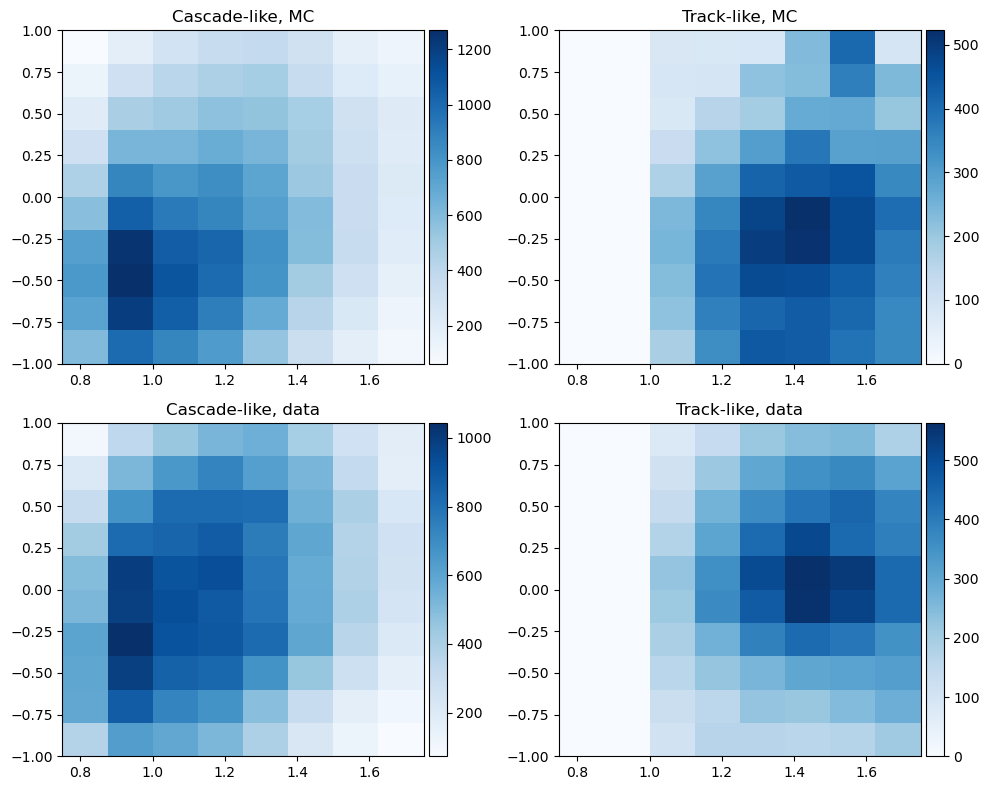

In [70]:
# Make a a 2x2 grid of subplots with 2D histograms. 
# The top row should be the combined MC data (i.e. neutrinos and muons)
# The bottom row should be the data
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(10, 8))
cmesh = ax1.pcolormesh(bins_en, 
                       bins_cz,
                       nu_hist[:,:,0] + muon_hist[:,:,0],
                       cmap='Blues')
ax1.set_title('Cascade-like, MC')
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(cmesh, cax)

cmesh = ax2.pcolormesh(bins_en,
                        bins_cz,
                        nu_hist[:,:,1] + muon_hist[:,:,1],
                        cmap='Blues')
ax2.set_title('Track-like, MC')
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(cmesh, cax)

cmesh = ax3.pcolormesh(bins_en,
                        bins_cz,
                        cascades_count,
                        cmap='Blues')
ax3.set_title('Cascade-like, data')
divider = make_axes_locatable(ax3)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(cmesh, cax)

track_padded = np.pad(track_count, ((0,0),(2,0)), 'constant', constant_values=0)
cmesh = ax4.pcolormesh(bins_en,
                        bins_cz,
                        track_padded,
                        cmap='Blues')
ax4.set_title('Track-like, data')
divider = make_axes_locatable(ax4)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(cmesh, cax)

fig.tight_layout()

The track-like data looks nothing like the track-like MC. Something seems to be wrong here. Is it the flux calculation perhaps? Or is it the fact that I have not taken the oscillations into account?

### Compare data with MC on 1D projections

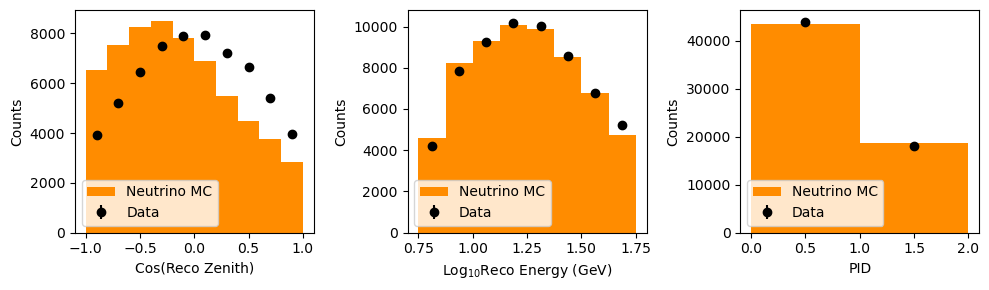

In [71]:
# Make a 3D histogram of the data where the track histogram has been padded with 0s to have the same shape as the cascades
track_padded = np.zeros_like(cascades_count)
track_padded[:, 2:] = track_count
data_hist = np.stack([cascades_count, track_padded], axis=-1)
# Make a projection on each 3D axis of histogram for both the data and MC
# Plot each projection on the same figure but in separate subplots
# Subtract the muon MC from the data histogram
# The MC data is a filled histogram, while the data is a scatter plot
fig, axs = plt.subplots(1,3, figsize=(10, 3))
for i, (ax, bins, xlabel) in enumerate(zip(axs, [bins_cz, bins_en, bins_pid], ("Cos(Reco Zenith)", r"Log$_{10}$Reco Energy (GeV)", "PID"))):
    axes_to_sum = tuple(set(range(3)) - set([i]))
    nu_mc_proj = nu_hist.sum(axis=axes_to_sum) + muon_hist.sum(axis=axes_to_sum)
    data_proj = data_hist.sum(axis=axes_to_sum)
    ax.stairs(nu_mc_proj, bins, fill=True, alpha=1, label="Neutrino MC", color="darkorange")
    ax.errorbar((bins[1:] + bins[:-1])/2, data_proj, yerr=np.sqrt(data_proj), fmt='o', label="Data", c="k")
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Counts")
    ax.legend()

fig.tight_layout()

In [72]:
int_type = (np.abs(neutrinos["pdg"]) == 16).astype(int) # non-tau neutrino is 0, tau neutrino NC is 1
int_type[(int_type == 1) & (neutrinos["type"] > 0)] = 2 # tau CC is 2

nontau = neutrinos[int_type == 0]
tau_nc = neutrinos[int_type == 1]
tau_cc = neutrinos[int_type == 2]

In [73]:
nontau_hist, _ = np.histogramdd([np.log10(nontau['reco_energy']),
                                 nontau['reco_coszen'],
                                 nontau['pid']],
                                bins = [bins_en, bins_cz, bins_pid],
                                weights = neutrino_weights[int_type == 0])

nontau_hist = np.swapaxes(nontau_hist, 0, 1)

tau_nc_hist, _ = np.histogramdd([np.log10(tau_nc['reco_energy']),
                                 tau_nc['reco_coszen'],
                                 tau_nc['pid']],
                                bins = [bins_en, bins_cz, bins_pid],
                                weights = neutrino_weights[int_type == 1])

tau_nc_hist = np.swapaxes(tau_nc_hist, 0, 1)

tau_cc_hist, _ = np.histogramdd([np.log10(tau_cc['reco_energy']),
                                 tau_cc['reco_coszen'],
                                 tau_cc['pid']],
                                bins = [bins_en, bins_cz, bins_pid],
                                weights = neutrino_weights[int_type == 2])

tau_cc_hist = np.swapaxes(tau_cc_hist, 0, 1)


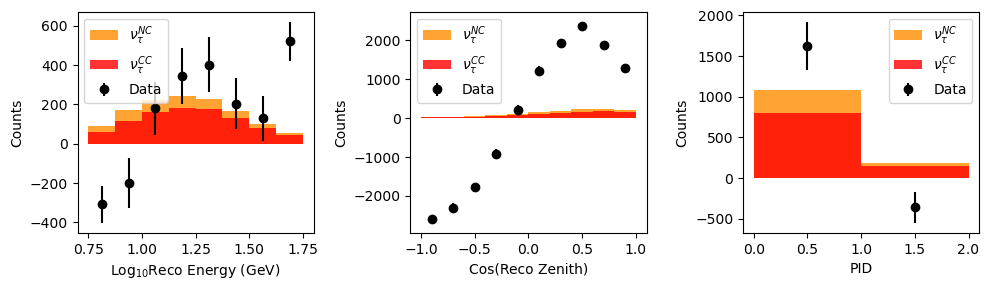

In [74]:
# Make a 3D histogram of the data where the track histogram has been padded with 0s to have the same shape as the cascades
track_padded = np.zeros_like(cascades_count)
track_padded[:, 2:] = track_count

data_signal_hist = data_hist - muon_hist - nontau_hist


# Make a projection on each 3D axis of histogram for both the data and MC
# Plot each projection on the same figure but in separate subplots
# Subtract the muon MC from the data histogram
# The MC data is a filled histogram, while the data is a scatter plot
fig, axs = plt.subplots(1,3, figsize=(10, 3))
for i, ax, bins, xlabel in zip((1, 0, 2), axs, [bins_en, bins_cz, bins_pid], (r"Log$_{10}$Reco Energy (GeV)", "Cos(Reco Zenith)", "PID")):
    axes_to_sum = tuple(set(range(3)) - set([i]))
    tau_nc_mc_proj = tau_nc_hist.sum(axis=axes_to_sum)
    tau_cc_mc_proj = tau_cc_hist.sum(axis=axes_to_sum)
    data_proj = data_signal_hist.sum(axis=axes_to_sum)
    # NOTE This is not perfectly accurate, since the MC errors are not a simple Poisson error
    data_proj_err = np.sqrt(
        np.sqrt(data_hist.sum(axis=axes_to_sum))**2 
        + np.sqrt(muon_hist.sum(axis=axes_to_sum))**2 
        + np.sqrt(nontau_hist.sum(axis=axes_to_sum))**2)

    ax.stairs(tau_nc_mc_proj + tau_cc_mc_proj, bins, fill=True, alpha=0.8, label=r"$\nu_\tau^{NC}$", color="darkorange")
    ax.stairs(tau_cc_mc_proj, bins, fill=True, alpha=0.8, label=r"$\nu_\tau^{CC}$", color="red")
    ax.errorbar((bins[1:] + bins[:-1])/2, data_proj, yerr=data_proj_err, fmt='o', label="Data", c="k")
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Counts")
    ax.legend()

fig.tight_layout()

^ The plots match much better now. This is good! 
However, there is still quite a large discrepancy. 
Maybe this is due to the interpolation being bad, maybe it is because of scaling of all events, maybe a bug in my flux calculation code.
TODO: test all these potential problems.
I do not see any scaling parameter for all events among the nuisance parameters. There is one normalization parameter for the NC events, so I will try to use that. 
I can try to apply a scaling of all events anyway to see if that gives a better result, and read in the paper if there is any mention of it.

## Calculate $\chi^2$ value
The data above is the sum of all backgrounds (muon background, non-neutrino backgrounds, and tau neutrino interactions). This should then be compared to the sum of all simulated backgrounds and signal to calculate how well the two distributions match. This is done using a $\chi^2$ test. The $\chi^2$ value is defined as:
$$
\chi^2 = \sum_{i\in \{bins\}} \frac{(N_i^{exp} - N_i^{obs})^2}{N_i^{exp} + (\sigma_i^{exp})^2} + \sum_{j\in\{syst\}} \frac{(s_j - \hat s_j)^2}{\sigma_{s_j}^2}
$$

- $N_i^{exp}$: expected number of events in bin $i$
- $N_i^{obs}$: observed number of events in bin $i$
- $\sigma_i^{exp}$: statistical uncertainty in bin $i$ due to the finite statistics of MC simulations. Maybe this can be calculated using the weighted errors of the MC events stored in the csv files? TODO ask Chad and Jason
- $s_j$: central value of nuisance parameter $j$
- $\hat s_j$: maximum likelihood estimate of nuisance parameter $j$
- $\sigma_{s_j}$: uncertainty in nuisance parameter $j$, from the Gaussian standard deviation of the nuisance parameter

The nuisance parameters, their standard deviations, and their best fit values can be found in table II of the paper.

The final $\chi^2$ value that was achieved for the best fit of all nuisance parameters was 127.6, so we expect to get a similar value.

Later, we want to change the value of the tau normalization to check what $\chi^2$ values we get in those situations.

In [75]:
# Calculate systematic uncertainties
nuisance_parameters = pd.DataFrame({
    "nue_numu_ratio": [1.0, 0.05, 1.03, 1.03],
    "nue_up_hor_flux_ratio": [0.0, 1., -0.42, -0.33],
    "spectral_index": [0., 0.1, 0.03, 0.03],
    "effective_livetime": [np.nan, np.nan, 2.21, 2.24],
    "M_A_quasielastic": [0.99, (0.248+0.149)/2, 1.05, 1.05], # Upper and lower bounds
    "M_A_resonance": [1.12, 0.22, 1., 0.99],
    "NC_norm": [1., 0.2, 1.05, 1.06],
    "theta_13": [8.5, 0.21, np.nan, np.nan],
    "theta_23": [np.nan, np.nan, 49.8, 50.2],
    "delta_m2_32": [np.nan, np.nan, 2.53, 2.56],
    "opt_eff_all": [100, 10, 98.4, 98.4],
    "opt_eff_lat": [0, 1, 0.49, 0.48],
    "opt_eff_headon": [np.nan, np.nan, -0.63, -0.64],
    "bulk_ice_scattering": [100, 10, 103, 102.8],
    "bulk_ice_absorption": [100, 10, 101.5, 101.7],
    "atm_mu_frac": [np.nan, np.nan, 8.1, 8.0],
    "mu_spectral_index": [0., 1., 0.15, 0.15],
    "coin_nu_mu_frac": [0., 0.1, 0.01, 0.01],   # TODO only +, not +-. Maybe the standard deviation is a fraction of 0.1?
    "nu_tau_norm": [np.nan, np.nan, 0.73, 0.57]
}, index=["prior", "prior_error", "best_fit_cc_nc", "best_fit_cc"]).T
nuisance_parameters

,prior,prior_error,best_fit_cc_nc,best_fit_cc
nue_numu_ratio,1.00,0.0500,1.03,1.03
nue_up_hor_flux_ratio,0.00,1.0000,-0.42,-0.33
spectral_index,0.00,0.1000,0.03,0.03
effective_livetime,NaN,NaN,2.21,2.24
M_A_quasielastic,0.99,0.1985,1.05,1.05
M_A_resonance,1.12,0.2200,1.00,0.99
NC_norm,1.00,0.2000,1.05,1.06
theta_13,8.50,0.2100,NaN,NaN
theta_23,NaN,NaN,49.80,50.20
delta_m2_32,NaN,NaN,2.53,2.56


In [76]:
systematics = nuisance_parameters.dropna(axis=0)
sys_chi2 = np.sum((systematics["prior"] - systematics["best_fit_cc_nc"])**2 / systematics["prior_error"]**2)
sys_chi2

1.4884860019687816

In [77]:
# MC total expected event counts
mc_hist = nu_hist + muon_hist
# Error on the number of events due to the limited MC statistics. 
# TODO can we add these errors like this? I think so but worth double-checking
mc_err = np.sqrt(nu_err**2 + muon_err**2)

In [78]:
mc_cascades = mc_hist[:,:,0]
mc_tracks = mc_hist[:,2:,1]
mc_cascade_err = mc_err[:,:,0]
mc_track_err = mc_err[:,2:,1]

chi2 = (
    np.sum((mc_cascades - cascades_count)**2 / (mc_cascades + mc_cascade_err**2))
    + np.sum((mc_tracks - track_count)**2 / (mc_tracks + mc_track_err**2))
    + sys_chi2
)

chi2

5097.300596797848

## Sanity check of data and MC
The data and MC counts should be the same as in table I

In [79]:
data["count"].sum()

62112.0

^ This is the same as in table I

In [80]:
nu_hist.sum() + muon_hist.sum()

62110.000000000015

^ This should be close to 62203. Though it is not a large difference, so maybe it is the error in the flux approximation of neutrinos.

In [81]:
muon_hist.sum()

5022.000000000001

^ This should be 5022 but is instead much larger. Why is that the case? This is very confusing.

## Plot neutrino flux for Honda model

In [82]:
flux = np.genfromtxt("spl-ally-01-01-solmax.d", delimiter=" ", skip_header=2)

Text(0, 0.5, 'Flux $(m^2~s~sr)^{-1}$')

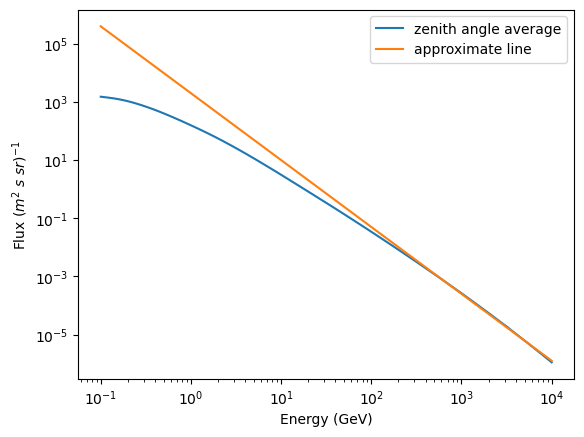

In [83]:
# plot nu_mu flux (col 2) as a function of energy (col 1)
plt.plot(flux[:,0], flux[:,1] * flux[:,0], label="zenith angle average")
plt.plot(flux[:,0], .2e4 * flux[:,0]**(-2.3), label="approximate line")
plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Energy (GeV)")
plt.ylabel("Flux $(m^2~s~sr)^{-1}$")